# HFT - Intraday volatility estimation from high frequency data


**Lucas RODRIGUEZ**

*Academic work - October/November/December 2022 - January 2023*

## Preliminary steps

### Introduction

In [1]:
# Importing all necessary libraries 
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import warnings
import copy

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

In [2]:
# Filename & respective folder
data_folder = "data/"
source_filename = data_folder + "IVE_tickbidask.txt"

# Defining the columns names (explicit broadcast)
columns_name = ["Date", "Time", "Price", "Bid", "Ask", "Size"]

# Importing the main dataset
df = pd.read_csv(filepath_or_buffer=source_filename,
                names=columns_name,
                decimal=".",
                parse_dates={'dt' : ['Date', 'Time']}, 
                infer_datetime_format=True, 
                low_memory=False,
                index_col='dt')

We copy the initial dataset, in case we want to deal with original data in the further processing steps.

In [3]:
# Copying the initial dataframe
df_copy = copy.deepcopy(df)

In [4]:
# Getting and printing some information about the imported dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10383278 entries, 2009-09-28 09:30:00 to 2022-10-28 16:00:00
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Price   float64
 1   Bid     float64
 2   Ask     float64
 3   Size    int64  
dtypes: float64(3), int64(1)
memory usage: 396.1 MB


In [5]:
# Printing the first and last trade records
df

,Price,Bid,Ask,Size
dt,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100
2009-09-28 09:30:00,50.71,50.70,50.79,638
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
...,...,...,...,...
2022-10-28 15:59:57,143.91,143.88,143.92,100
2022-10-28 15:59:58,143.90,143.89,143.92,100
2022-10-28 15:59:58,143.89,143.87,143.91,100


In [6]:
# Statistical description of the final dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,10383278.0,102.565078,27.425201,0.11,86.66,103.1101,116.52,163.43
Bid,10383278.0,102.555424,27.425930,0.00,86.66,103.1100,116.51,160.38
Ask,10383278.0,102.573037,27.427433,0.00,86.67,103.1200,116.53,604.85
Size,10383278.0,241.993778,4271.681409,0.00,100.00,100.0000,200.00,5157948.00


### Dataset description


This dataset represents all the trade operations occurring from **2009-09-28 09:30:00** to **2022-10-28 16:00:00** (time range denoted here as $\mathbf{T}$), for the IVE index (iShares  S&P 500 Value ETF). It's composed of 4 different columns (after quick formating during dataset import): **Price,Bid,Ask,Size**; the **Date** and **Time** act as index columns.

> The order of the fields in the tick files (with bid/ask prices) is: **Date,Time,Price,Bid,Ask,Size**. Our bid/ask prices are recorded whenever a trade occurs and they represent the "national best bid and offer" (NBBO) prices across multiple exchanges and ECNs.

> For each trade, current best bid/ask values are recorded together with the transaction price and volume. Trade records are not aggregated and all transactions are included in their consecutive order.

> The order of fields in our regular tick files **(without bid/ask)** is: **Date,Time,Price,Size**.

*Source*: http://www.kibot.com/Support.aspx#tick_data_format

In [7]:
df.head()

,Price,Bid,Ask,Size
dt,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100
2009-09-28 09:30:00,50.71,50.70,50.79,638
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100


### Data pre-processing

However, we only need the price column denoted as $S_t$ which we have assumed to represent the price of the asset at time $t$ (value of the last occurring transaction).

In [8]:
# Removing useless columns
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Bid', 'Ask', 'Size'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")

In [9]:
# Printing the first and last trade records
df

,Price
dt,
2009-09-28 09:30:00,50.79
2009-09-28 09:30:00,50.71
2009-09-28 09:31:32,50.75
2009-09-28 09:31:32,50.75
2009-09-28 09:31:33,50.75
...,...
2022-10-28 15:59:57,143.91
2022-10-28 15:59:58,143.90
2022-10-28 15:59:58,143.89


**References**:
1. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

We can resample the price $(S_t)_t$ observations with custome time frequency (here: hourly):

In [10]:
df.resample("H").mean().head()

,Price
dt,
2009-09-28 09:00:00,51.048208
2009-09-28 10:00:00,51.277057
2009-09-28 11:00:00,51.360257
2009-09-28 12:00:00,51.460638
2009-09-28 13:00:00,51.498606


**Remark**: We can observe that the resampling operation creates a lot of NaN values, which corresponds to non-traded hours in our case. For these time slots, there is no existing records in the initial dataset, that's why the called aggregation method returns a NaN value.

We have to deal with these NaN values in order to successfully answer the given issue.

$\longrightarrow$ The best way to handle them is by:
1. **dropping the NaN rows** 
2. or by **replacing them by a specific value**



Since option 2 is not a relevant and reliable solution; it's non-sense to replace NaN values by any statistical indicator, since there is no market activity during these hours.

$\longrightarrow$ We choose to remove those elements.

**Reference**:
1. https://stackoverflow.com/questions/44770839/resampling-a-pandas-dataframe-by-business-days-gives-bad-results
2. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
3. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offset-semantics
4. https://stackoverflow.com/questions/44770839/resampling-a-pandas-dataframe-by-business-days-gives-bad-results

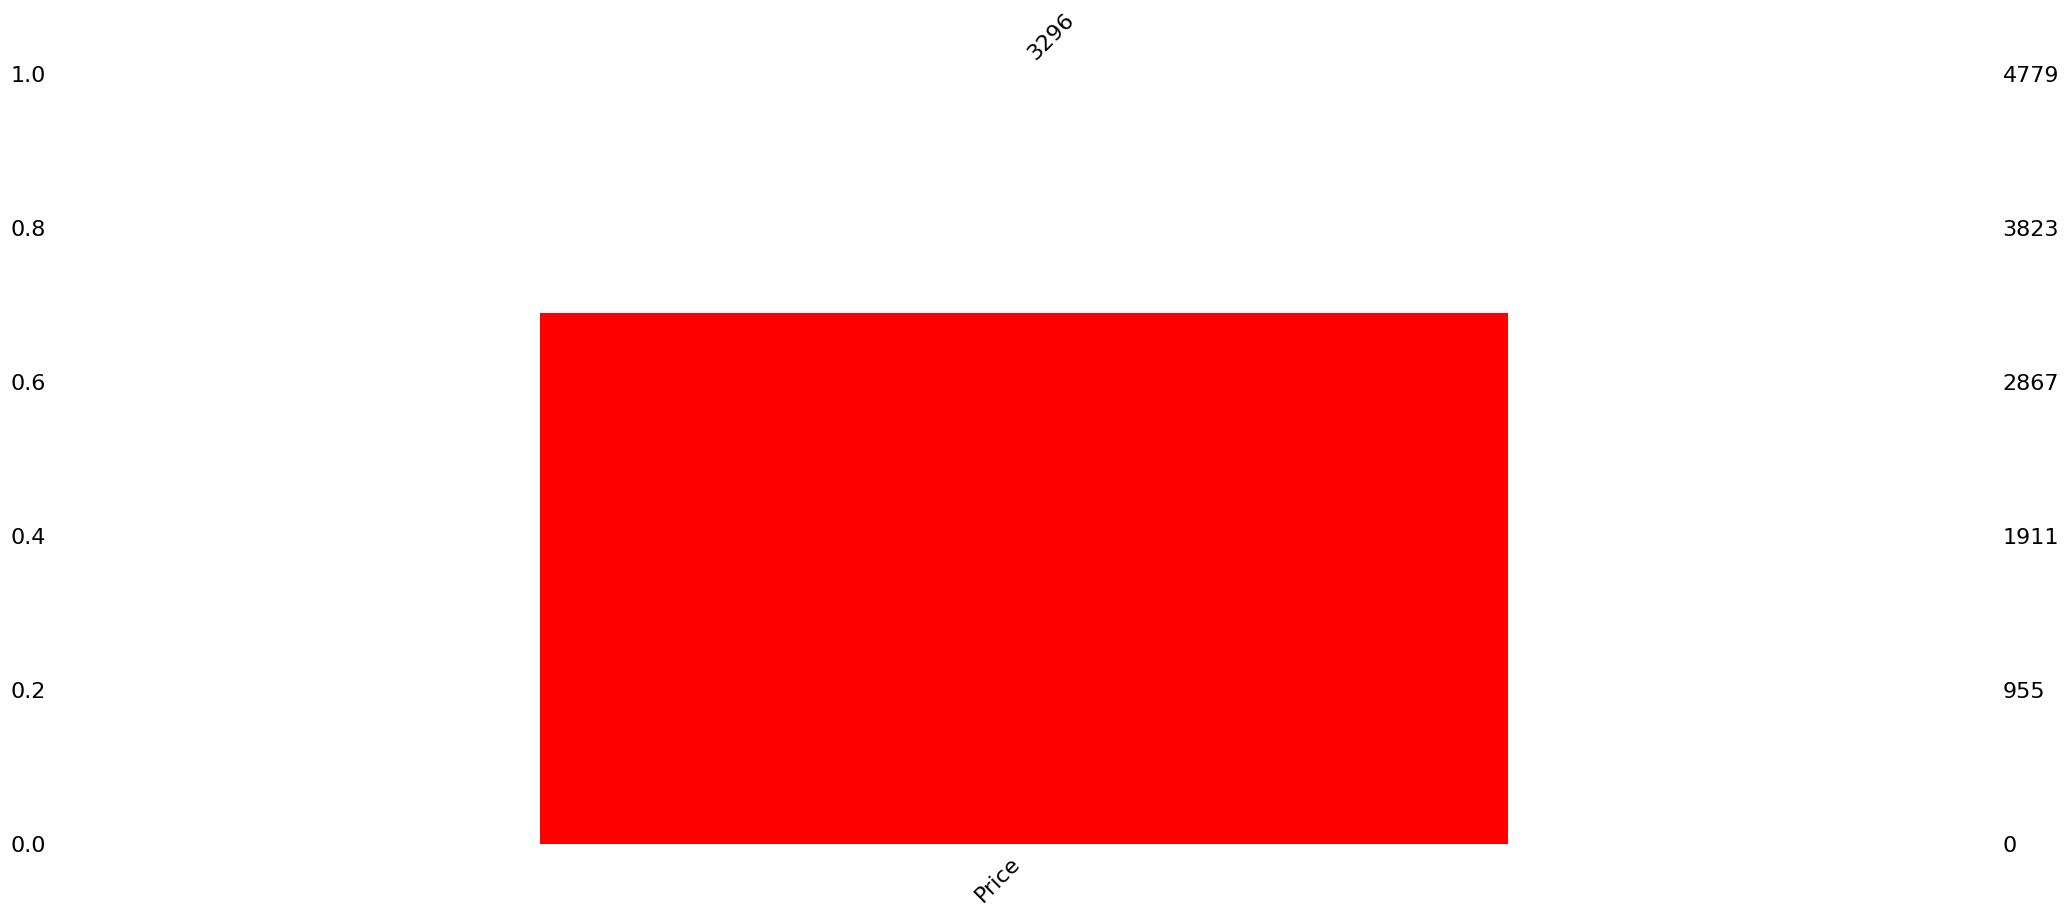

In [11]:
_ = msno.bar(df.resample("D").mean(), color="red")

### Data visualization

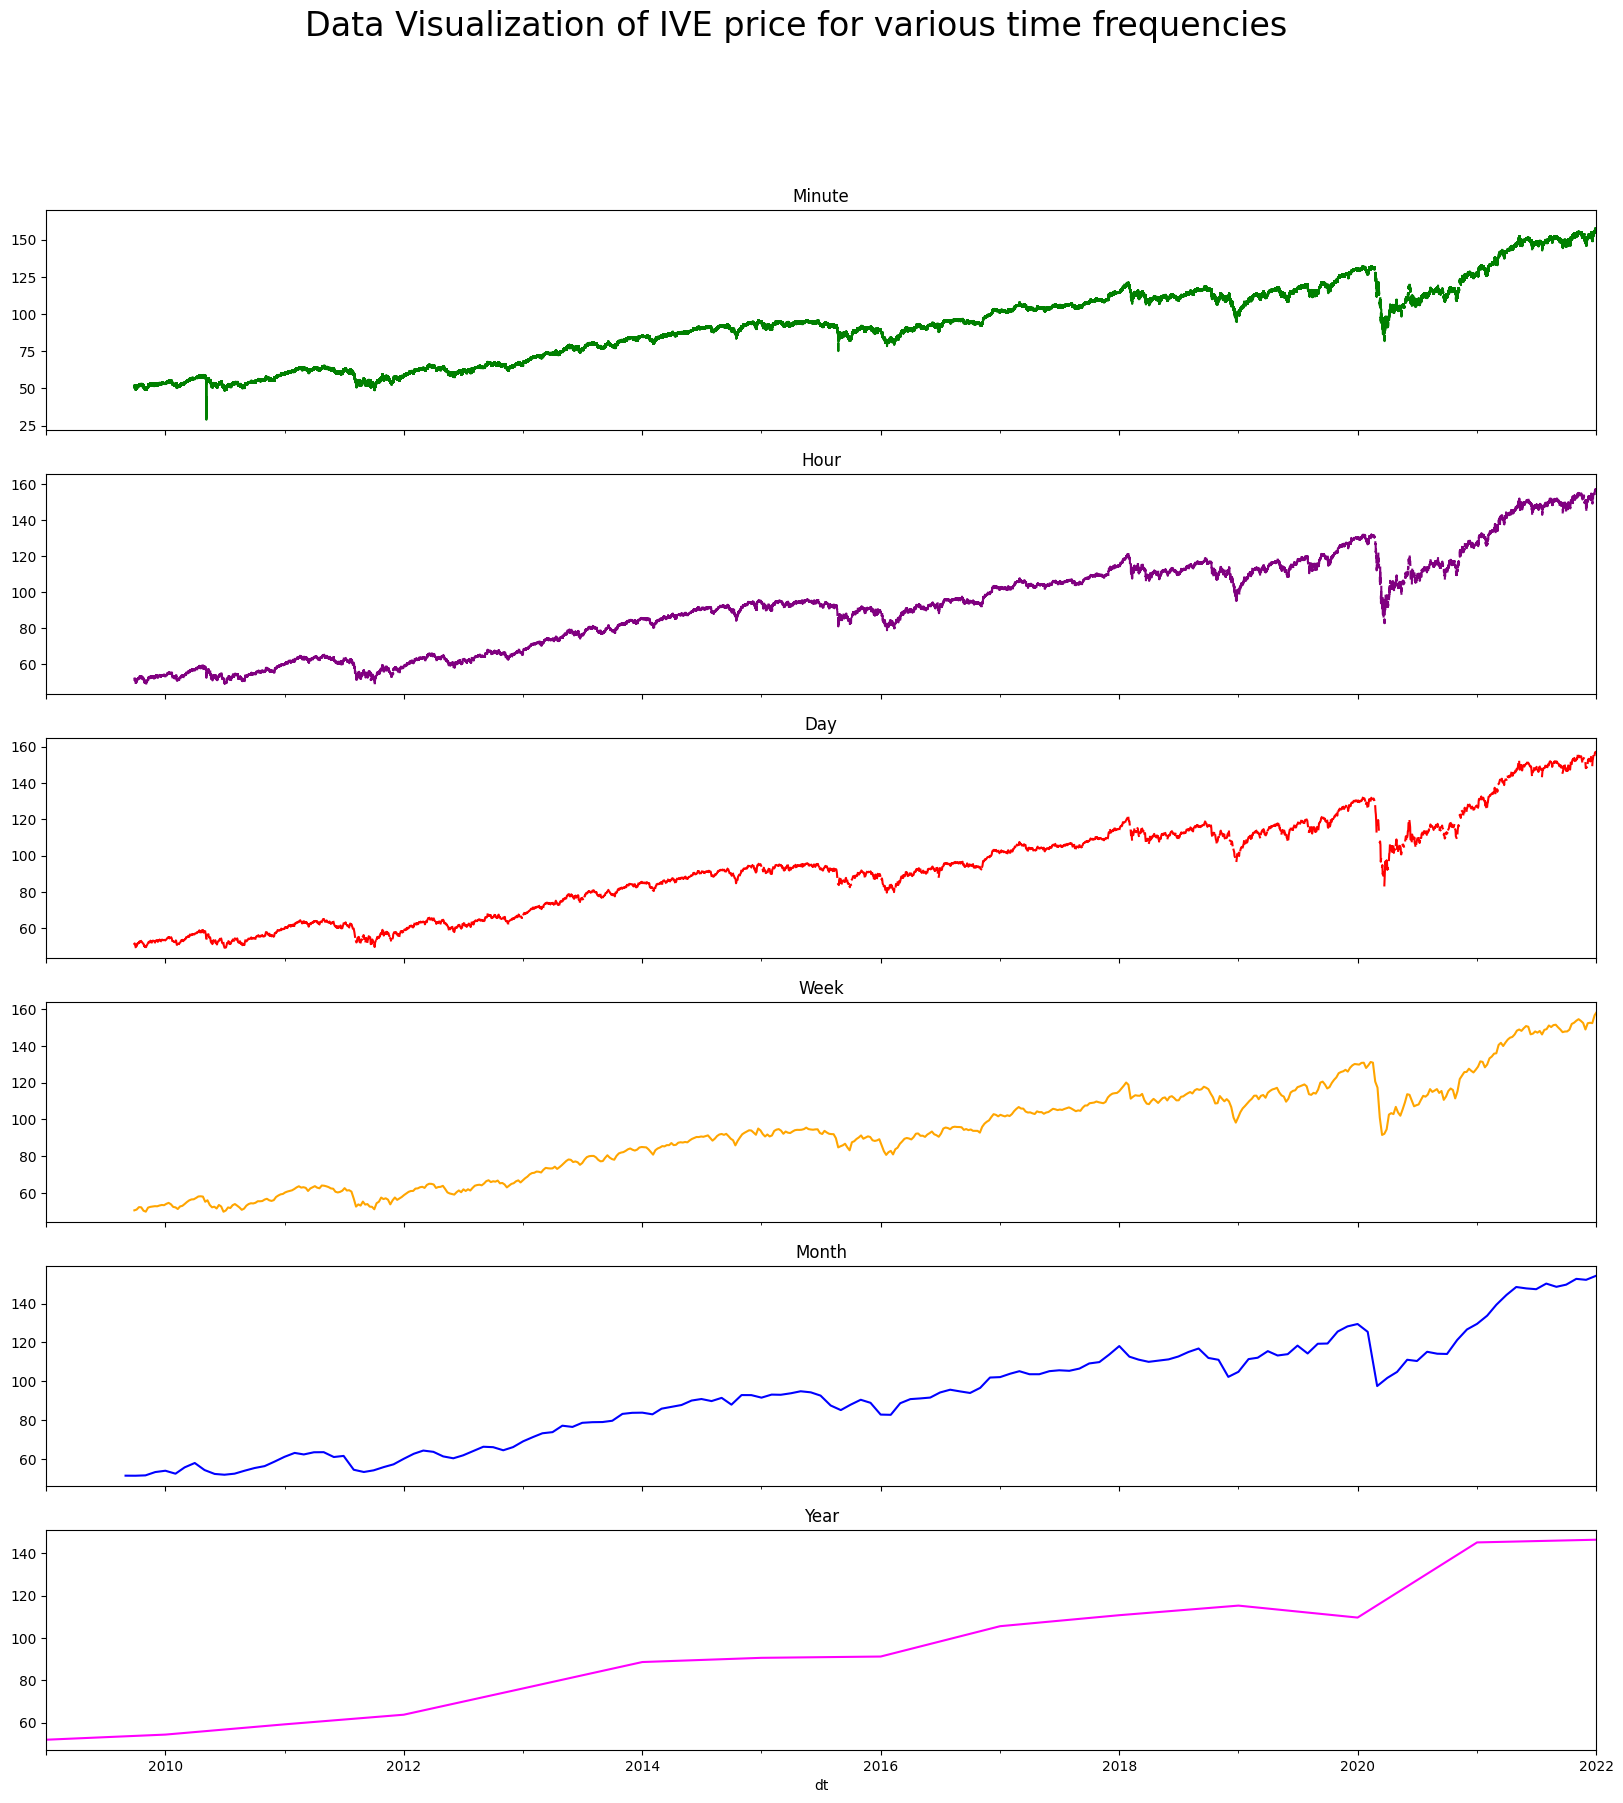

In [12]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(20, 20), sharex=True)
fig.suptitle("Data Visualization of IVE price for various time frequencies", fontsize=24)

# Visualization of IVE price for various time frequencies
_ = df["Price"].resample("T").mean().plot(color="green", title="Minute", ax = axes[0])
_ = df["Price"].resample("H").mean().plot(color="purple", title="Hour", ax=axes[1])
_ = df["Price"].resample("D").mean().plot(color="red", title="Day", ax = axes[2])
_ = df["Price"].resample("W").mean().plot(color="orange", title="Week", ax = axes[3])
_ = df["Price"].resample("M").mean().plot(color="blue", title="Month", ax = axes[4])
_ = df["Price"].resample("Y").mean().plot(color="magenta", title="Year", ax = axes[5])

In order to deal with the log-returns time series, we will define $(X_t)_t$ as the **log-price process**:

$$
\forall t \in \mathbf{T}, \ X_t := \log (S_t)
$$

In [13]:
# Log-price process
df_log = np.log(df)

We have seen that the trade operations occurring on this index are only being executed between 9:30 and 16:00. In order to plot the daily evolution of the price, we will plot from 9:00 to 17:00 for safety.

In [14]:
# Defining the indices for traded hours (for daily price plotting purposes)
HOURS_INDEX = [str(k) for k in list(range(9, 18))]

We now are defining a specific function which formats and returns the opening and closing hours of a trading day.

In [15]:
# Defining a function which formats and returns the opening and closing hours of a trading day
TIME_BOUNDARIES = {"MORNING": "09:00:00", "AFTERNOON": "17:00:00"}
get_boundaries_datetimes = lambda day: (day + " " + TIME_BOUNDARIES["MORNING"], day + " " + TIME_BOUNDARIES["AFTERNOON"])

We now are collecting the trade operations on the IVE index for 1 day

In [16]:
# Small example
start_dt = "2019-10-10 09:00:00"
end_dt = "2019-10-10 17:00:00"
data = df[start_dt : end_dt]

# Showing first rows of the results
data.head()

,Price
dt,
2019-10-10 09:30:00,116.43
2019-10-10 09:33:35,116.50
2019-10-10 09:33:37,116.47
2019-10-10 09:33:37,116.47
2019-10-10 09:33:37,116.47


In [17]:
get_boundaries_datetimes("2019-10-09")

('2019-10-09 09:00:00', '2019-10-09 17:00:00')

In [18]:
def get_daily_price_process(day: str = "2018-10-08", process_type: str = "std") -> pd.DataFrame:
    """
    Function returning the daily price data
    """
    if process_type not in ["std", "log"]:
        print("dd")
        raise Exception("The given process parameter is not correct.")
    
    start_dt, end_dt = get_boundaries_datetimes(day)
    assert start_dt != end_dt
    return get_price_process(start_dt=start_dt, end_dt=end_dt, process_type=process_type)

In [19]:
def get_price_process(start_dt: str = "", end_dt: str = "", process_type: str = "std") -> pd.DataFrame:
    """
    Function returning the price process for the given day, with the given process type
    - std = standard (without any transformation)
    - log = log-price process is returned
    """
    if process_type not in ["std", "log"]:
        raise Exception("The given process parameter is not correct.")
    
    assert start_dt != end_dt
    
    if process_type == "std":
        data = df[start_dt : end_dt]
    else:
        data = df_log[start_dt : end_dt]
    
    nb_data = len(data)
    
    if nb_data == 0:
        raise Exception("This day does not contain any trade operations.")
    return data

In [20]:
def plot_daily_price(day: str = "2018-10-08", process_type: str = "std") -> None:
    """
    Function returning the plotting representation of the price
    """

    fig, ax = plt.subplots(figsize=(15, 10))
    
    data = get_daily_price_process(day, process_type=process_type)
    nb_data = len(data)
    start_dt, end_dt = get_boundaries_datetimes(day)

    _ = data.plot(rot=35, ax=ax, color="red")

    t = pd.date_range(start=start_dt,
                  end=end_dt,
                  periods=9)
    _ = ax.set_xticks(t)
    ax.set_xticklabels(HOURS_INDEX)
    
    # Setting title, x and y-labels
    _ = plt.title(rf"Evolution of the price for IVE" 
                  + "\n" 
                  + f"Start: {start_dt} $\longrightarrow$ End: {end_dt}"
                  + "\n"
                  + f"Number of trade operations: {nb_data}")
    _ = plt.xlabel("Intraday hours")
    _ = plt.ylabel("Price of the given security")

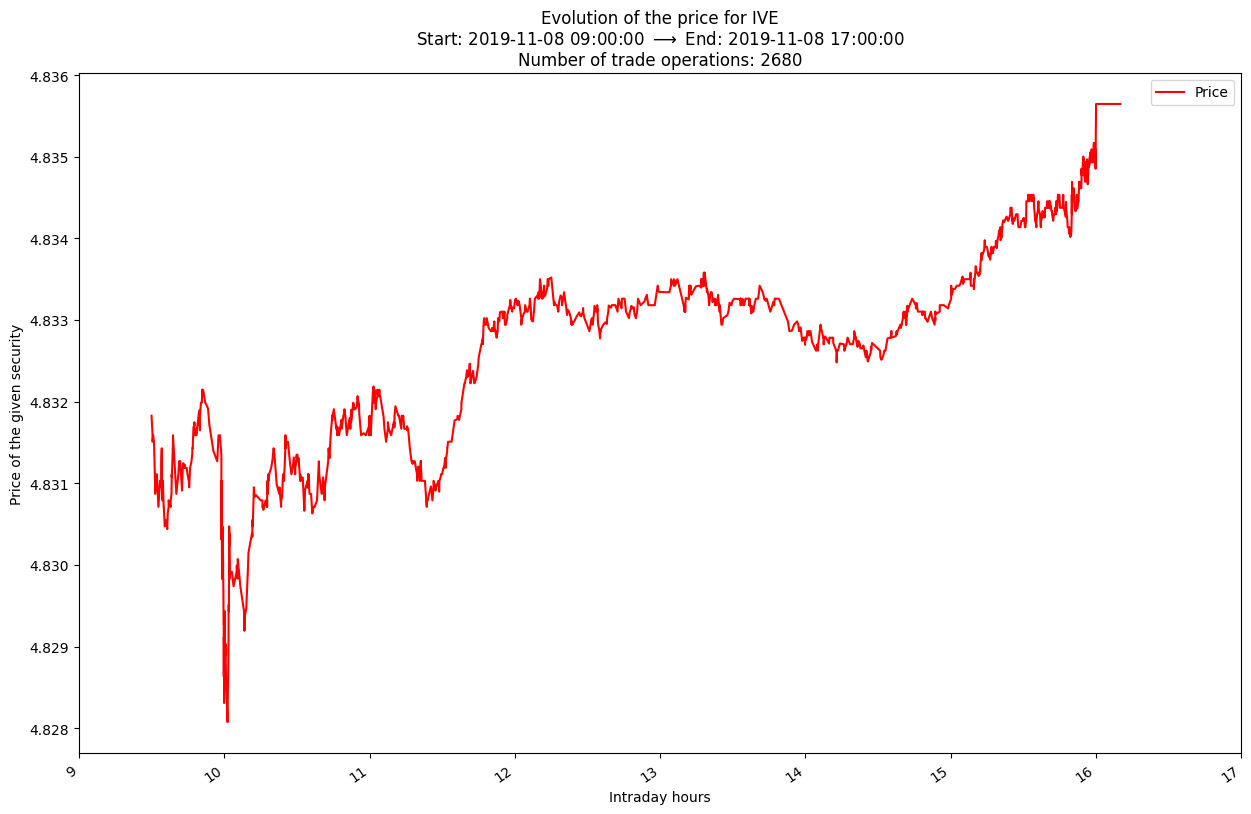

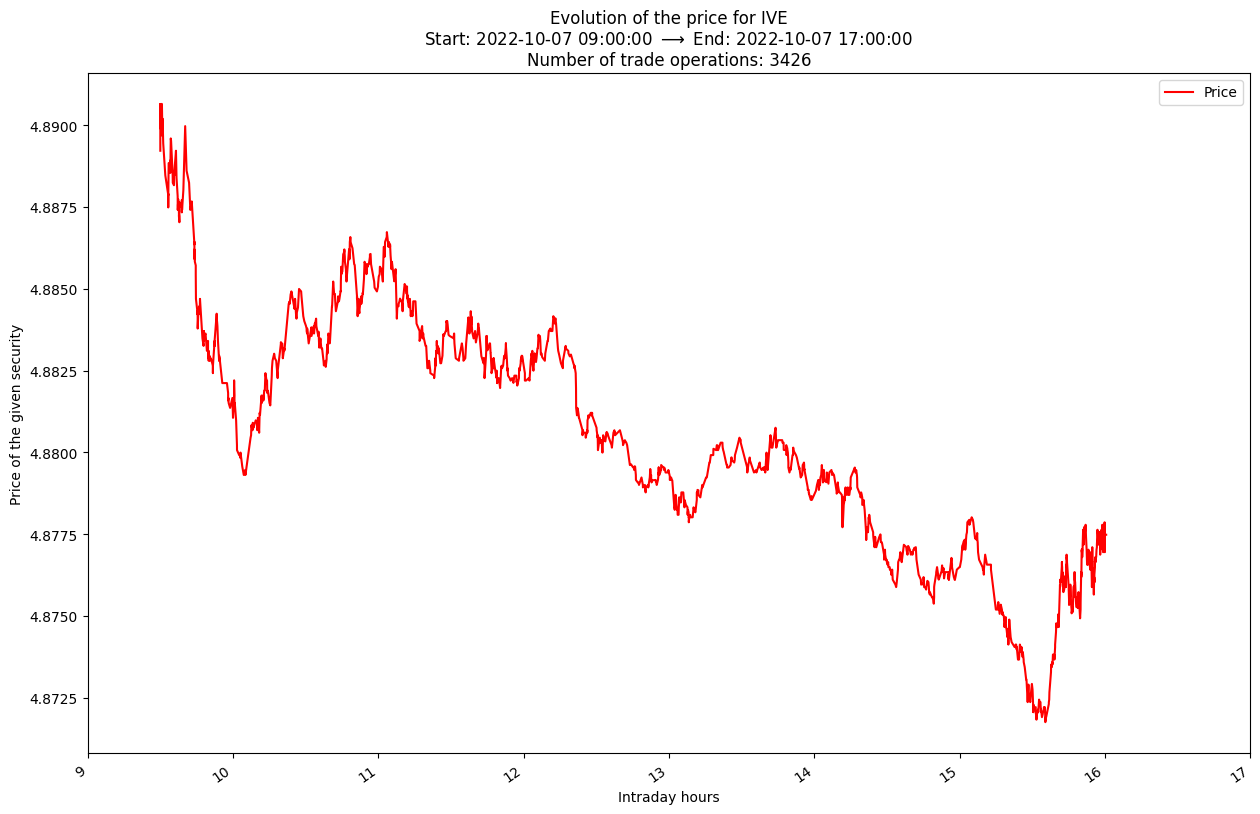

In [21]:
plot_daily_price("2019-11-08", "log")
plot_daily_price("2022-10-07", "log")

After some research, the value of the S&P 500 index is only updated thanks to markets movements from 9:30 to 16:00. However, for plotting reasons, we will keep our actual time range (9:00 to 17:00) in our implementation.

## Estimation of realized volatility with various observation frequencies

We wan to compute the **realized volatility**; to do so, we will use this estimator:

$$
\boxed{\widehat{Q}_n := \sum_{i = 0}^{n - 1} \Big( \widehat{X}_{\frac{i + 1}{n}} - \widehat{X}_{\frac{i}{n}}  \Big)^2}
$$
where:
- $\widehat{X}_{\frac{i + 1}{n}}$ is the log-price in high-frequency, **observed on the market**.
- $n$ is the number of data points at such frequency.
- $\widehat{Q}_n$ is the **estimated realized volatility**.

In [308]:
# Tested observation frequencies
OBSERVATION_FREQS = ["30S", "32S", "35S", "40S", "45S", "50S", "1T", "90S", "2T", "150S", "3T", "5T", "8T", "10T", "12T", "15T"]

# Real labels for each time frequency
REAL_NAMES = ["30S", "32S", "35S", "40S", "45S", "50S", "1M", "1M30", "2M", "2M30", "3M", "5M", "8M", "10M", "12M", "15M"]

# Hash table (dictionnary) for results
REALIZED_VOL = {freq: 0.0 for freq in OBSERVATION_FREQS}

# Fixed day
FIXED_DAY = "2022-01-03"

# Computing the realized volatilities
for freq in OBSERVATION_FREQS:
    print(f"Considered frequency: {freq}")
    
    # Collecting the log-price process
    log_price = get_daily_price_process(day=FIXED_DAY, process_type="log")

    # Resampling
    log_price_resampled = log_price.resample(freq).mean()
    print(f"--> Trade operations: {len(log_price_resampled)}")

    # Computing the diff (X_{(i + 1)/n} - X_{(i)/n})
    diff_elements = log_price_resampled.diff()
    
    # Dropping the resulting NaN row
    diff_elements.dropna(inplace=True)
    
    # Computing the square of each difference
    squared_diff_elements = np.square(diff_elements) # diff_elements.applymap(lambda x: x**2)
    
    # Summing all the squared differences
    REALIZED_VOL[freq] = squared_diff_elements.sum()["Price"]

Considered frequency: 30S
--> Trade operations: 801
Considered frequency: 32S
--> Trade operations: 751
Considered frequency: 35S
--> Trade operations: 686
Considered frequency: 40S
--> Trade operations: 601
Considered frequency: 45S
--> Trade operations: 534
Considered frequency: 50S
--> Trade operations: 481
Considered frequency: 1T
--> Trade operations: 401
Considered frequency: 90S
--> Trade operations: 267
Considered frequency: 2T
--> Trade operations: 201
Considered frequency: 150S
--> Trade operations: 161
Considered frequency: 3T
--> Trade operations: 134
Considered frequency: 5T
--> Trade operations: 81
Considered frequency: 8T
--> Trade operations: 51
Considered frequency: 10T
--> Trade operations: 41
Considered frequency: 12T
--> Trade operations: 34
Considered frequency: 15T
--> Trade operations: 27


**Remark**: We can observe that the number of trade operations between two different days is not constant and depends on the market participants.

In [262]:
REALIZED_VOL

{'30S': 2.853842257302148e-05,
 '32S': 2.934315779237405e-05,
 '35S': 2.800953221401721e-05,
 '40S': 3.115441323247815e-05,
 '45S': 3.196952524702489e-05,
 '50S': 3.247558817461244e-05,
 '1T': 3.6321434291838745e-05,
 '90S': 3.641572094588038e-05,
 '2T': 3.6890916341098406e-05,
 '150S': 3.6433043085946284e-05,
 '3T': 3.195069404060458e-05,
 '5T': 3.0337405802341726e-05,
 '8T': 2.9267336644928787e-05,
 '10T': 1.9193319273217277e-05,
 '12T': 2.3218518362813882e-05,
 '15T': 2.2064301433026893e-05}

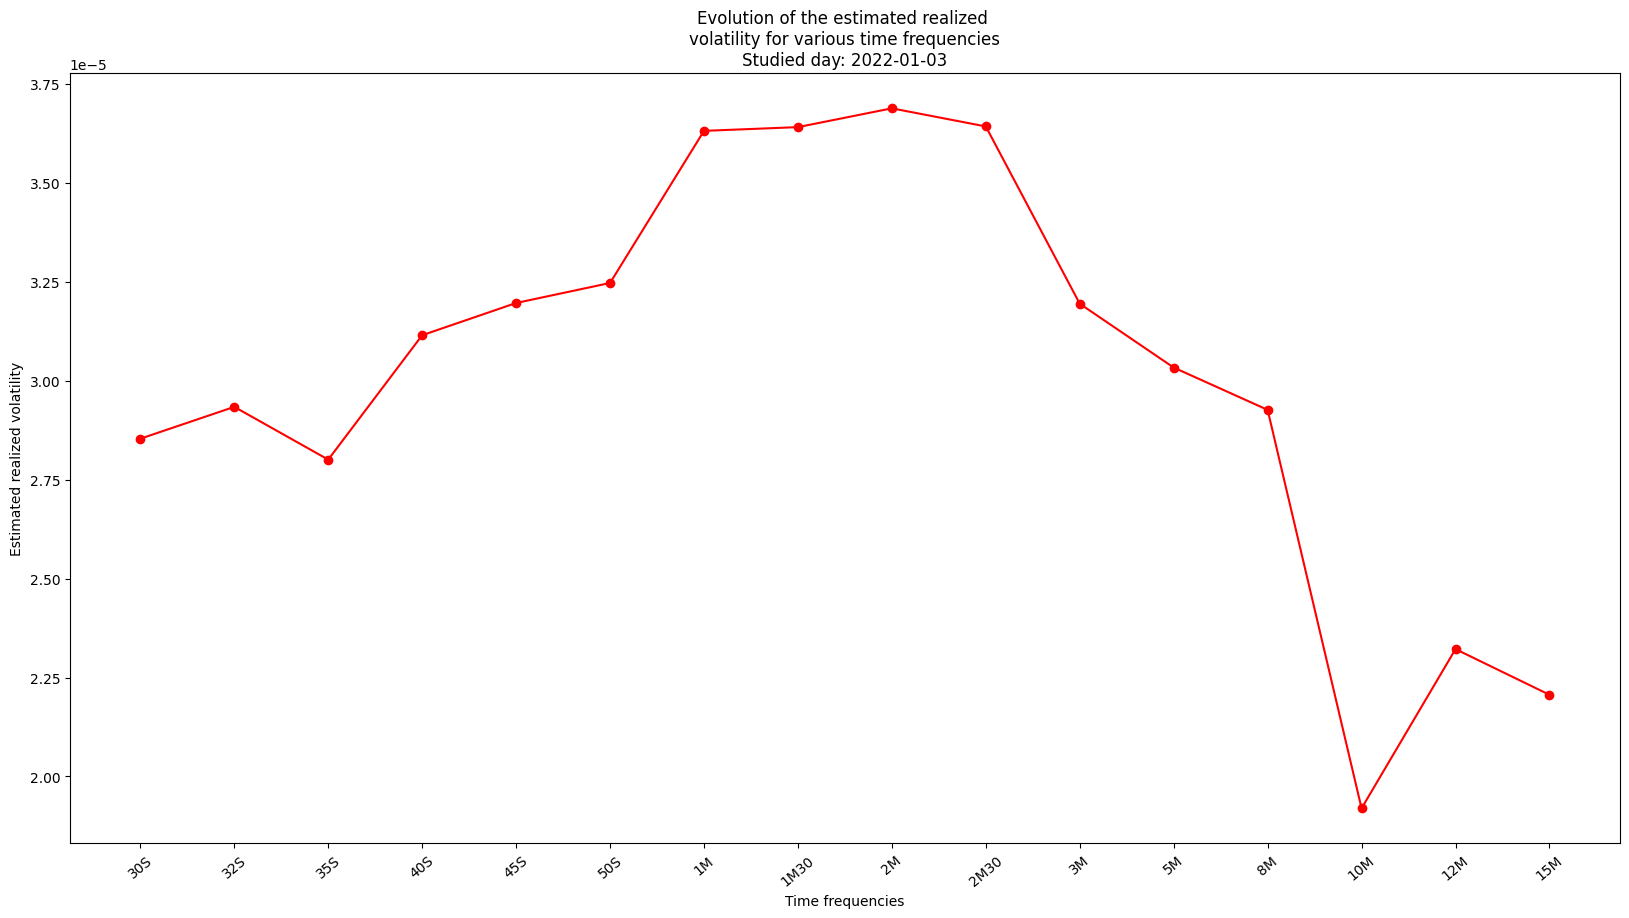

In [263]:
REALIZED_VOL2 = pd.Series(REALIZED_VOL)
plt.figure(figsize=(20, 10))
REALIZED_VOL2.plot(rot=40, marker='o', color="red")
_ = plt.xticks(list(range(len(OBSERVATION_FREQS))), REAL_NAMES)
_ = plt.title(f"Evolution of the estimated realized \nvolatility for various time frequencies\nStudied day: {FIXED_DAY}")
_ = plt.xlabel("Time frequencies")
_ = plt.ylabel("Estimated realized volatility")

In [254]:
# Saving results to disk for the report
REALIZED_VOL2.to_latex("out/out.tex")

## Comparison with long range estimation of the volatility

We now want to compare these results with the long range estimation of the volatility (based on higher period of time); for instance, 1 month of daily data.

In [287]:
# Defining the date limits for the month of January 2022
start_dt = "2022-01-01" + " " + TIME_BOUNDARIES["MORNING"]
end_dt = "2022-02-01" + " " + TIME_BOUNDARIES["MORNING"]

# Getting the respective financial data
monthly_data = get_price_process(start_dt=start_dt, 
                                 end_dt=end_dt, 
                                 process_type="log")

monthly_data_resampled = monthly_data.resample("1D").mean()

# Dropping weekends and holidays (non-trading days)
monthly_data_resampled.dropna(inplace = True)

# Computing the diff (X_{(i + 1)/n} - X_{(i)/n}) (log-returns)
log_returns = monthly_data_resampled.diff()

# Computing the long-range estimation of the volatility
long_range_est_vol = np.sqrt(log_returns.std())

In [311]:
long_range_est_vol["Price"]

0.09959841735242793

In [313]:
np.mean(REALIZED_VOL2 - long_range_est_vol["Price"])

-0.09956819339433698

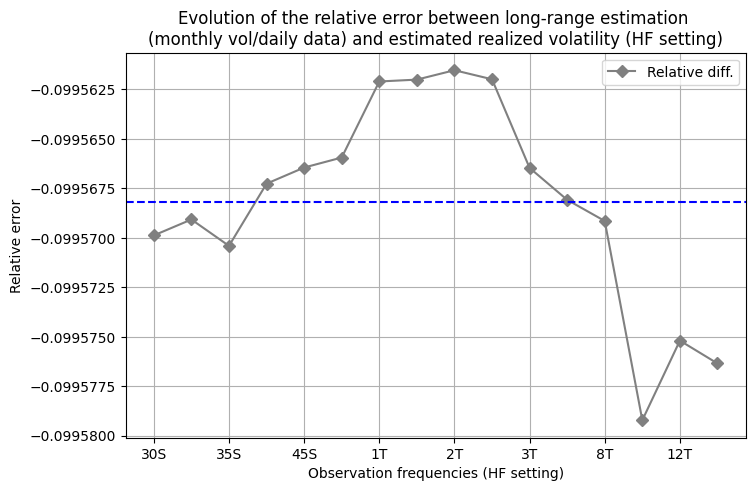

In [316]:
plt.figure(figsize=(8, 5))
plt.title("Evolution of the relative error between long-range estimation \n(monthly vol/daily data) and estimated realized volatility (HF setting)")
_ = (REALIZED_VOL2 - long_range_est_vol["Price"]).plot(color="gray", marker="D", label="Relative diff.")
_ = plt.legend()
_ = plt.grid()
_ = plt.axhline(y = np.mean(REALIZED_VOL2 - long_range_est_vol["Price"]), color="blue", label="mean", ls="--")
_ = plt.xlabel("Observation frequencies (HF setting)")
_ = plt.ylabel("Relative error")

## Estimation of $\vartheta$, micro-structure noise size

### Estimation with asymptotical result

We denote $\vartheta$, the micro structure noise size of the market. Our goal is to estimate its value.

As a reminder, we know that:

$$
\frac{1}{n}\widehat{Q}_n \longrightarrow 2\vartheta^2
$$
so, thanks to this theoretical result, we can recover a good estimator of $\vartheta$.

$$
\Longrightarrow \boxed{\vartheta = \lim_{n \rightarrow + \infty} \sqrt{(2n)^{-1}\widehat{Q}_n}}
$$


In order to conduct a small comparison study on this estimation, we will estimate this quantity with the previous values of the **estimated realized volatility** computed in the sections above.

This will help us to study the impact of the observation frequency on the microstructure noise size estimation.

In [317]:
MICROSTRUCT_NOISE_SIZE = {freq: 0.0 for freq in OBSERVATION_FREQS}

for freq in OBSERVATION_FREQS:
    print(f"Considered frequency: {freq}")
    
    # Collecting the log-price process
    #log_price = get_daily_price_process(day=FIXED_DAY, process_type="log")
    
    # Getting the respective financial data
    log_price = get_price_process(start_dt=start_dt, 
                                 end_dt=end_dt, 
                                 process_type="log")
    
    # Resampling with the observation frequency
    log_price_resampled = log_price.resample(freq).mean()
    
    # Getting the total number of samples
    n = len(log_price_resampled)
    
    # Getting the pre-computed estimated realized volatility
    Qn = REALIZED_VOL[freq]
    
    # Computing and storing the microstructure noise size estimation
    MICROSTRUCT_NOISE_SIZE[freq] = np.sqrt((1/(2*n))*Qn)

Considered frequency: 30S
Considered frequency: 32S
Considered frequency: 35S
Considered frequency: 40S
Considered frequency: 45S
Considered frequency: 50S
Considered frequency: 1T
Considered frequency: 90S
Considered frequency: 2T
Considered frequency: 150S
Considered frequency: 3T
Considered frequency: 5T
Considered frequency: 8T
Considered frequency: 10T
Considered frequency: 12T
Considered frequency: 15T


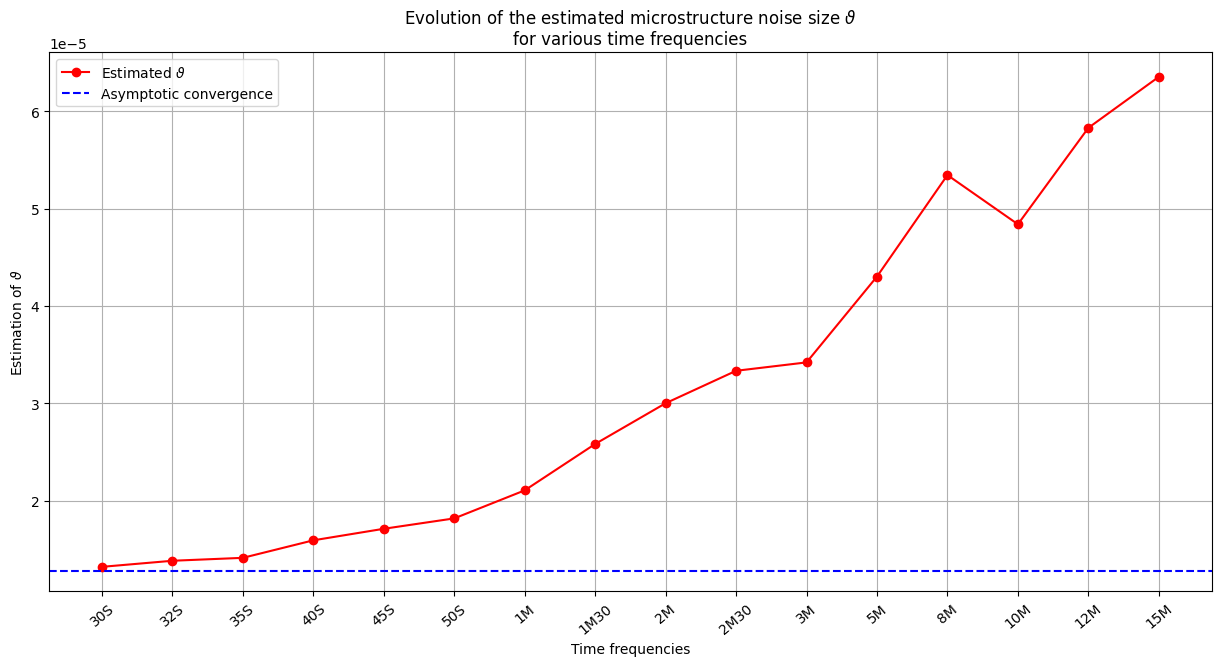

In [339]:
MICROSTRUCT_NOISE_SIZE2 = pd.Series(MICROSTRUCT_NOISE_SIZE)
plt.figure(figsize=(15, 7))
MICROSTRUCT_NOISE_SIZE2.plot(rot=40, marker='o', color="red", label=r"Estimated $\vartheta$")
_ = plt.axhline(y = 1.28e-5, color="blue", label="Asymptotic convergence", ls="--")
_ = plt.xticks(list(range(len(OBSERVATION_FREQS))), REAL_NAMES)
_ = plt.title(r"Evolution of the estimated microstructure noise size $\vartheta$ " + "\nfor various time frequencies")
_ = plt.xlabel("Time frequencies")
_ = plt.ylabel(r"Estimation of $\vartheta$")
_ = plt.grid()
_ = plt.legend()

**Observation**: We can easily see as $n \longrightarrow + \infty$, the given estimator of the microstructure noise size $\vartheta$ seems to converge towards $1.2\times 10^{-5}$.

### Estimation with autocorrelation between the returns at different scales

In order to deal with the $\rho(\cdot)$ and $\gamma(\cdot)$ functions and avoid any misunderstanding, we define them again as follows:

In [41]:
def autocorrelation(data, lag: int = 1) -> float:
    """
    Function computing and returning the autocorrelation value
    """
    return data.autocorr(lag = lag)

def autocovariance(data, lag: int = 1) -> float:
    """
    Function computing and returning the autocovariance value
    """
    return autocorrelation(data, lag = lag) * data.var()

We run some tests for the same log-price series with different lags for $\rho(\cdot)$ and $\gamma(\cdot)$.

In [42]:
# Testing the functions
print(autocovariance(df_log["Price"], lag = 1))
print(autocorrelation(df_log["Price"], lag = 1))
print(autocovariance(df_log["Price"], lag = 2000))

0.08197036860108921
0.9999315468730526
0.08191347348826665


In [59]:
# Getting the respective financial data
#log_price = get_daily_price_process(day="2022-09-16", process_type="log")

# Getting the respective financial data
log_price = get_price_process(start_dt=start_dt, end_dt=end_dt, process_type="log")
#log_price = log_price.resample("1D").mean()
log_returns = log_price.diff()
log_returns.fillna(0, inplace=True) #.dropna(inplace=True)
log_returns = log_returns["Price"]

In [68]:
autocovariance(data=log_returns, lag=1)

-1.0785031737829513e-08

**Assumption**: $(\varepsilon_{\frac{i}{n}})_{i \in \lbrace 0 \ldots n\rbrace}$ is an iid sequence $\mathcal{N}(0, 1)$.


So, we have $\mathbf{Var}(\varepsilon_{\frac{i}{n}}) = 1$.

In [74]:
MICROSTRUCTURE_NOISE_SIZE = np.sqrt(abs(autocovariance(data=log_returns, lag=1)))
print(f"Microstructure noise size: {MICROSTRUCTURE_NOISE_SIZE}")

Microstructure noise size: 0.00010385100739920395


In [61]:
LAGS = list(range(200))
AC = [autocovariance(data=log_returns, lag=lag) for lag in LAGS]

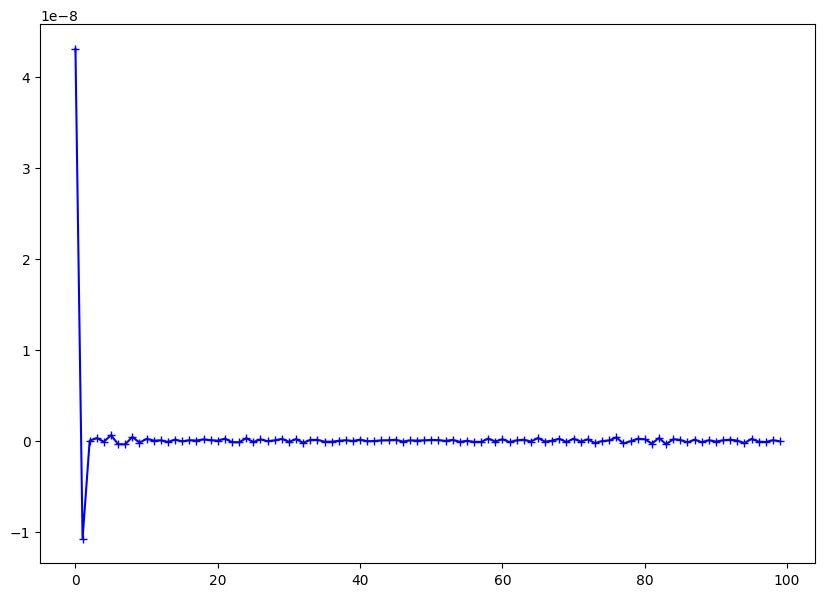

In [73]:
plt.figure(figsize=(10, 7))
_ = plt.plot(LAGS, AC, marker="+", color="b")

### <span style="color:red">[Complement]</span> ACF plotting

As an extra work, we have decided to plot the autocorrelation function (ACF) for the daily-sampled log-price process

In [64]:
a = df_log["Price"].resample("D").mean()
a = a.diff()
a.dropna(inplace=True)
b = a.to_numpy()

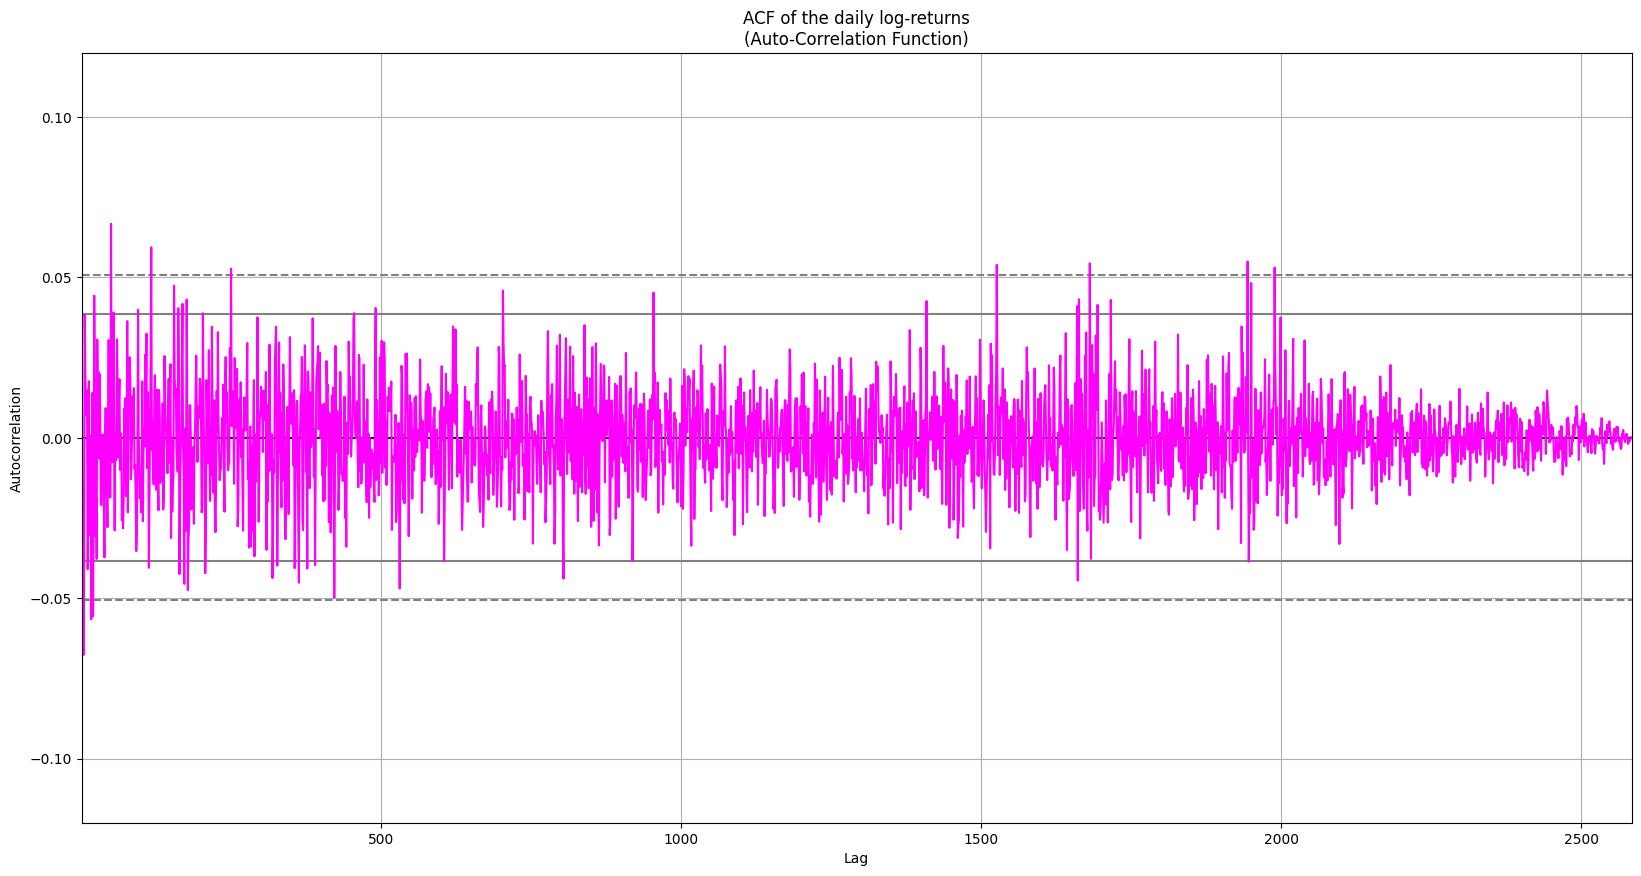

In [65]:
plt.figure(figsize=(20, 10))
_ = pd.plotting.autocorrelation_plot(a, color="magenta")
_ = plt.ylim([-0.12, 0.12])
_ = plt.title("ACF of the daily log-returns\n(Auto-Correlation Function)")

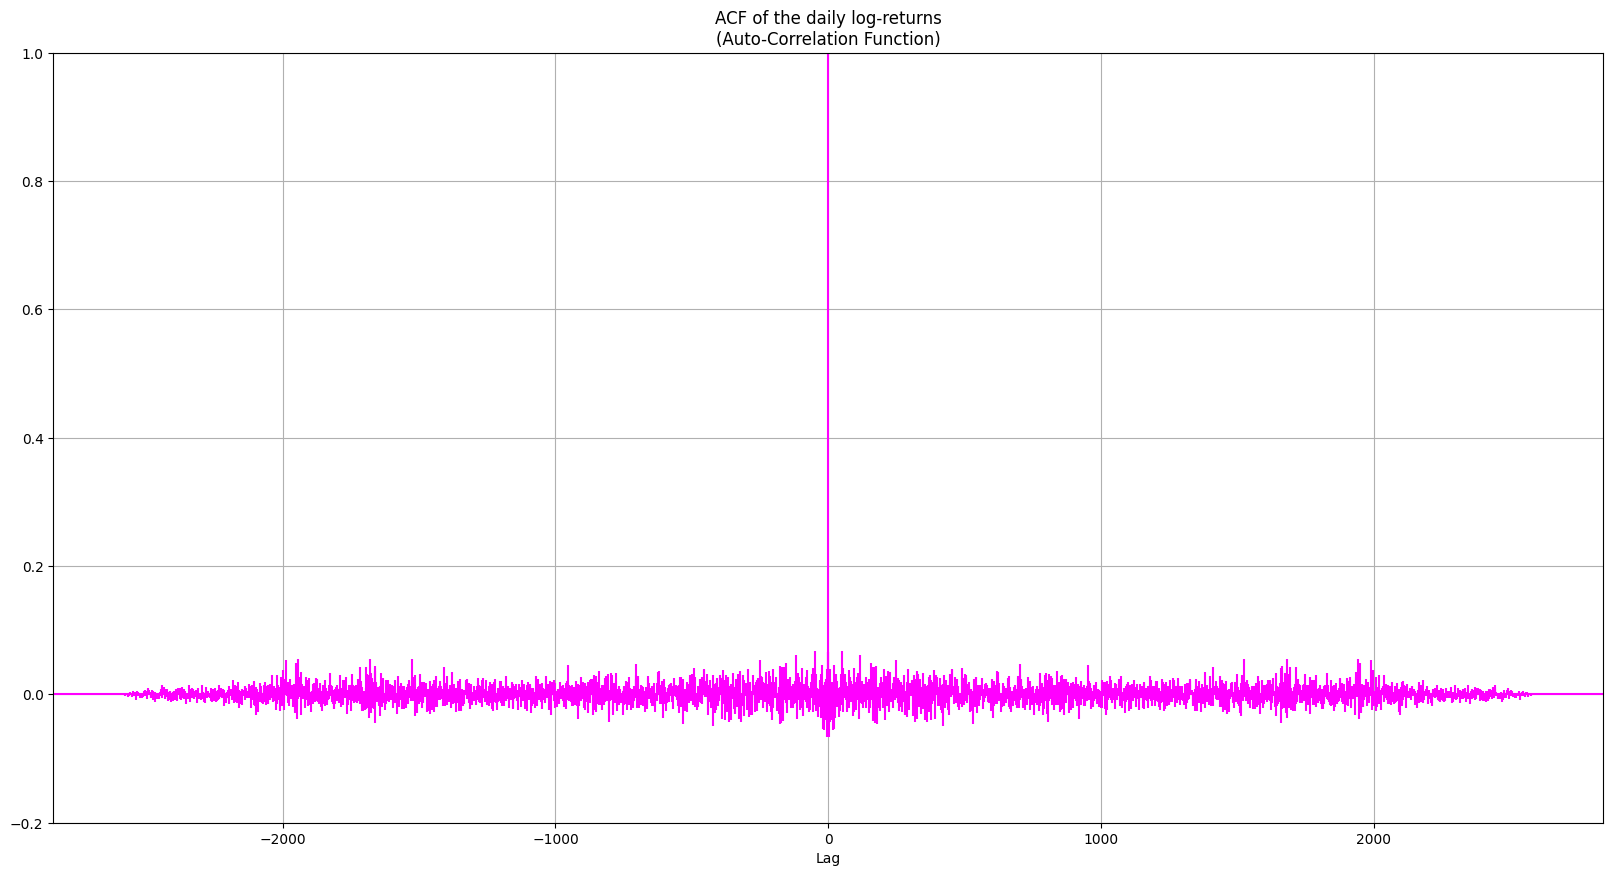

In [66]:
plt.figure(figsize=(20, 10))
_ = plt.acorr(a, maxlags= 2583, color="magenta")
_ = plt.ylim([-0.2, 1])
_ = plt.grid()
_ = plt.title("ACF of the daily log-returns\n(Auto-Correlation Function)")
_ = plt.xlabel("Lag")

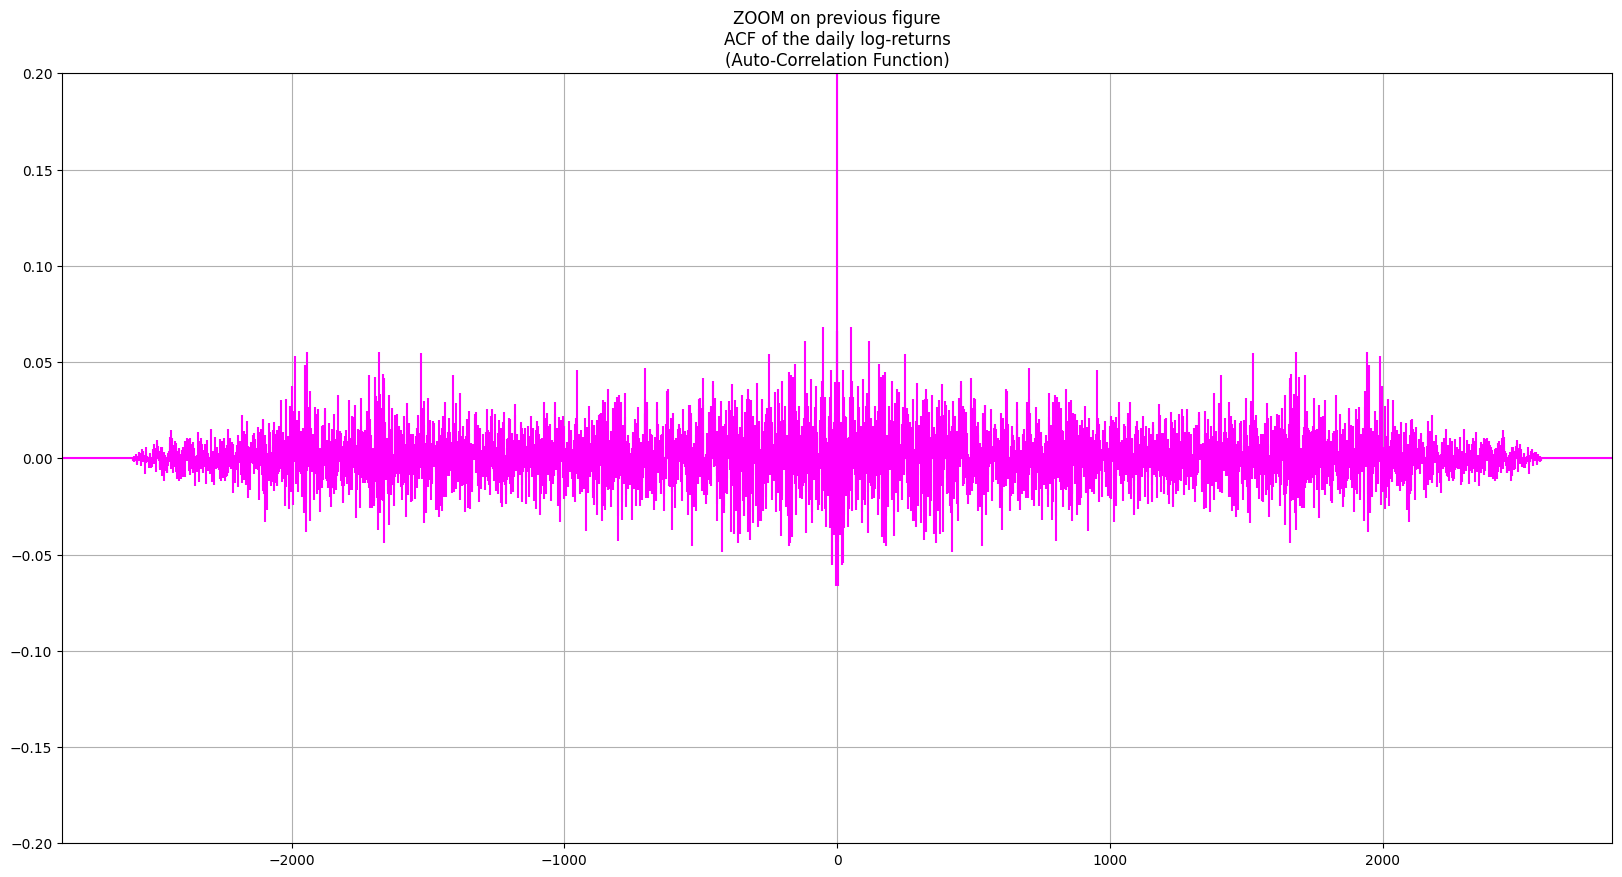

In [67]:
plt.figure(figsize=(20, 10))
_ = plt.acorr(a, maxlags= 2583, color="magenta")
_ = plt.ylim([-0.2, 0.2])
_ = plt.grid()
_ = plt.title("ZOOM on previous figure\nACF of the daily log-returns\n(Auto-Correlation Function)")

## Evolution of the estimated daily volatility of the IVE over the last year

In order to accurately answer this question, we have selected a 1-year time range in order to compute the estimated daily volatility evolution.

However, we have decided to choose the 2020 FY, so that we can easily recover the different markets strike due to the COVID-19 pandemic.


**Remark**: This period is a great example because we can easily point out the effect of Covid-19 on the stock market.

In [124]:
# Defining the date limits for the year 2020
start_dt = "2020-01-01" + " " + TIME_BOUNDARIES["MORNING"]
end_dt = "2021-01-01" + " " + TIME_BOUNDARIES["MORNING"]

# Getting the respective financial data
data = get_price_process(start_dt=start_dt, 
                                 end_dt=end_dt, 
                                 process_type="log")

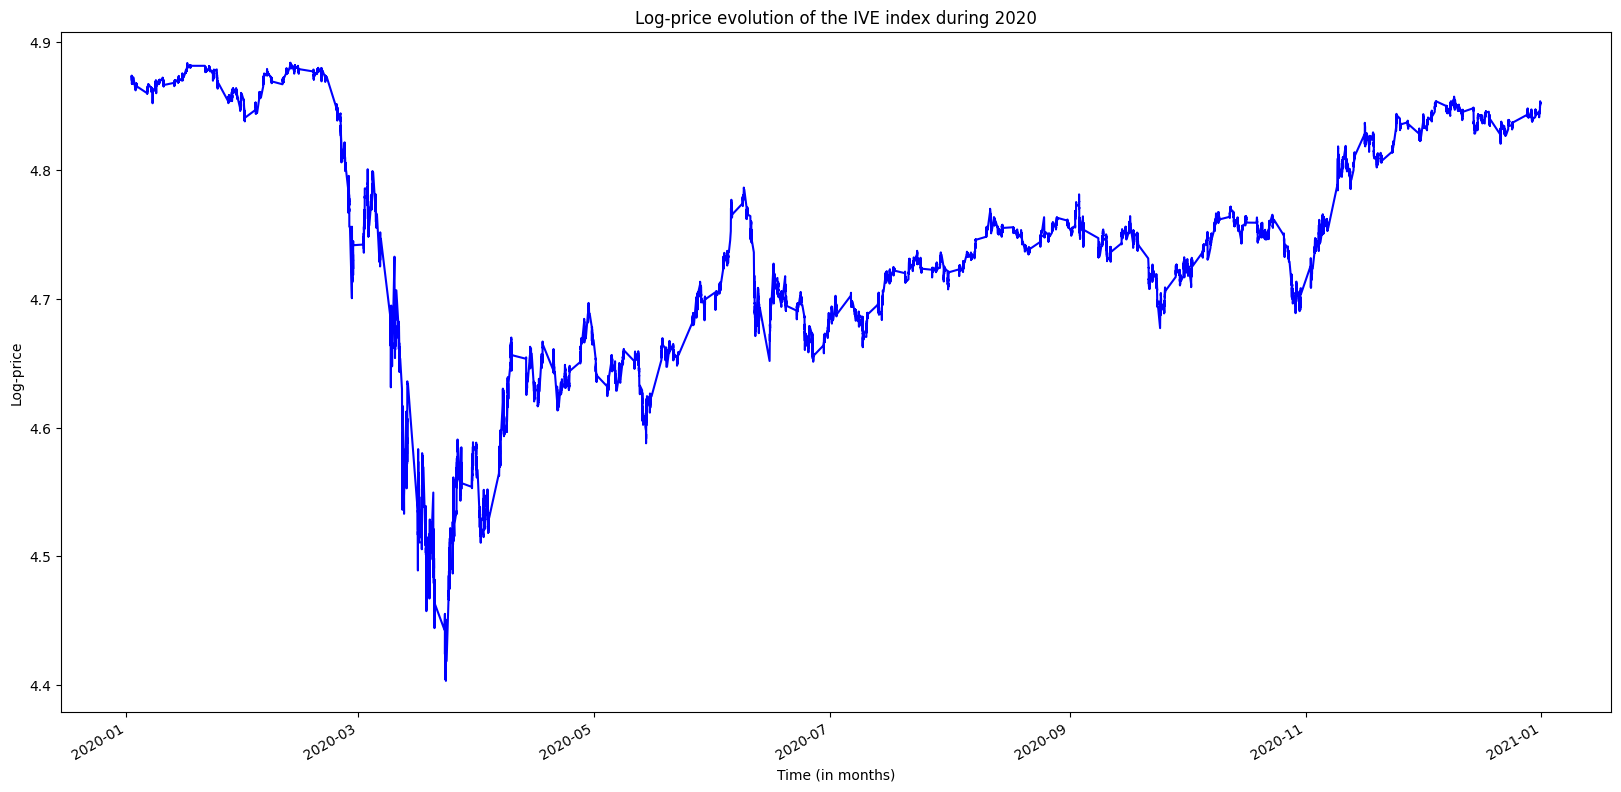

In [125]:
plt.figure(figsize=(20, 10))
price = data["Price"]
_ = price.plot(color="blue")
_ = plt.title("Log-price evolution of the IVE index during 2020")
_ = plt.xlabel("Time (in months)")
_ = plt.ylabel("Log-price")

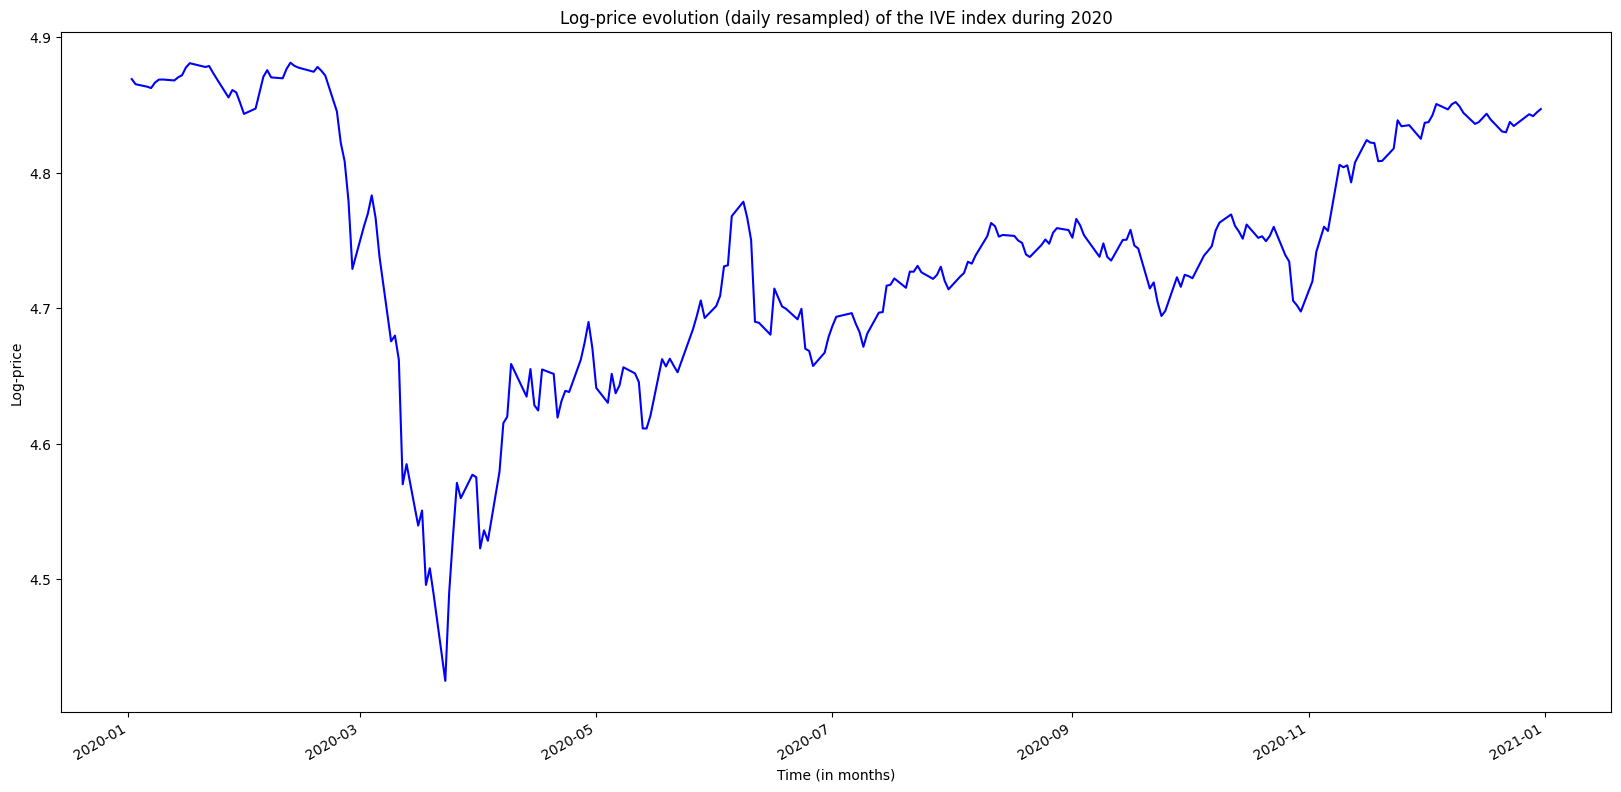

In [126]:
plt.figure(figsize=(20, 10))
price_daily_resampled = price.resample("D").mean().dropna()
_ = price_daily_resampled.plot(color="blue")
_ = plt.title("Log-price evolution (daily resampled) of the IVE index during 2020")
_ = plt.xlabel("Time (in months)")
_ = plt.ylabel("Log-price")

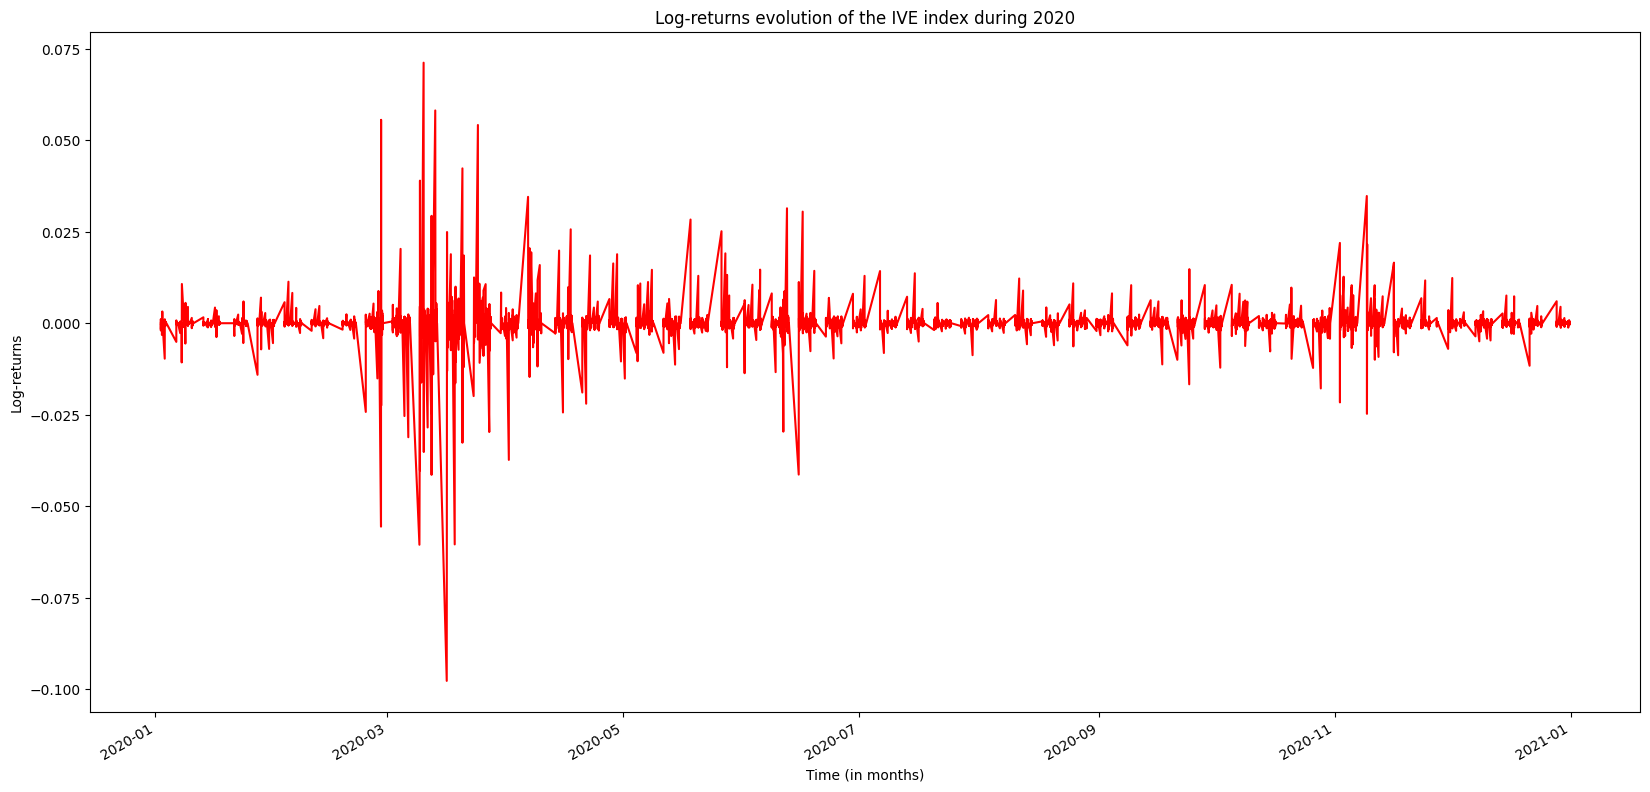

In [130]:
plt.figure(figsize=(20, 10))
log_returns = price.diff().dropna()
_ = log_returns.plot(color="red")
_ = plt.title("Log-returns evolution of the IVE index during 2020")
_ = plt.xlabel("Time (in months)")
_ = plt.ylabel("Log-returns")

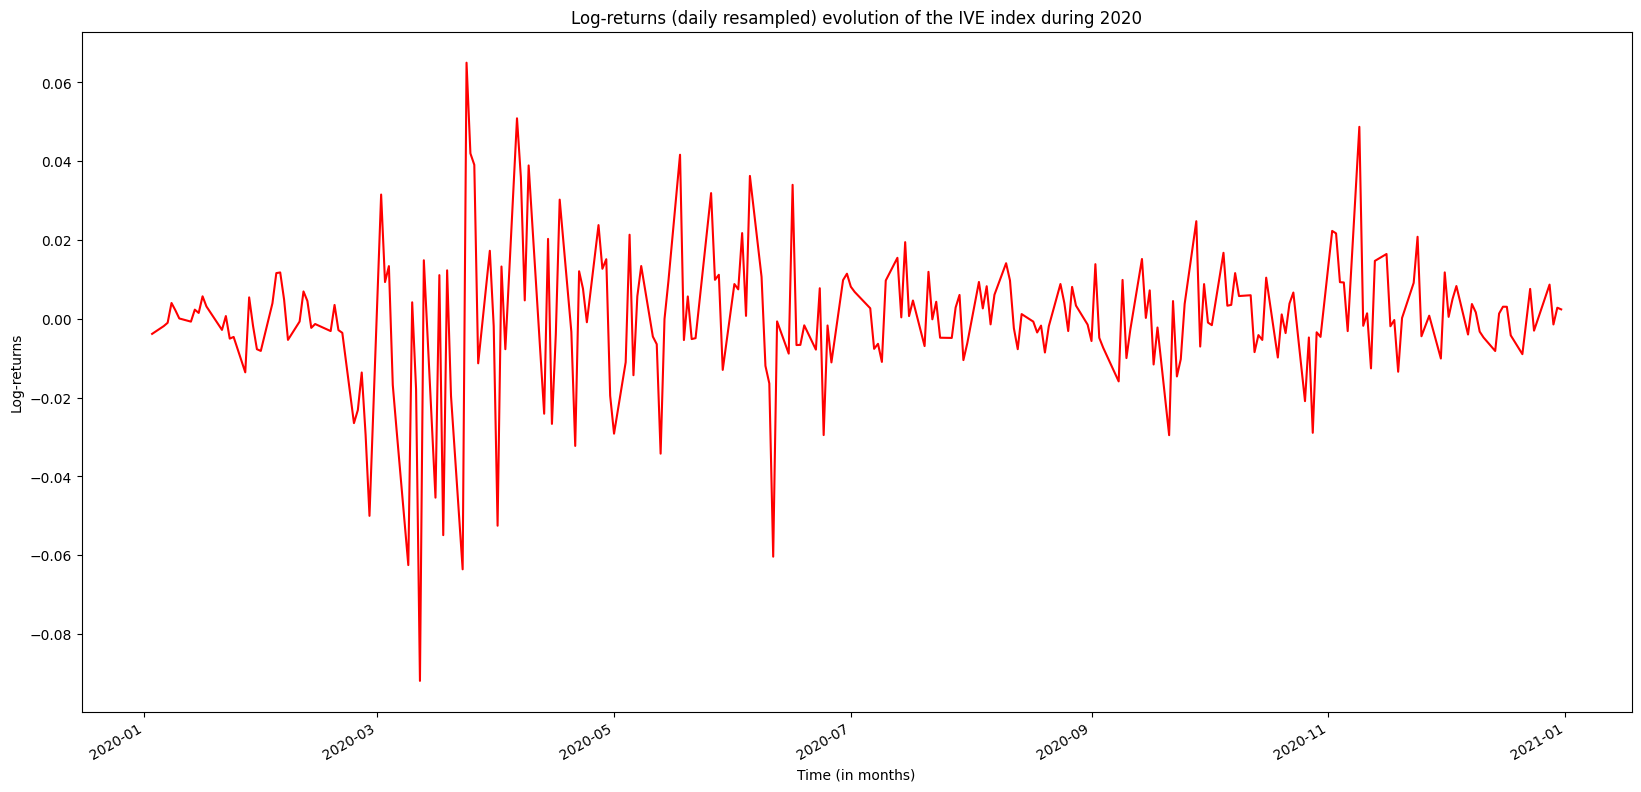

In [131]:
plt.figure(figsize=(20, 10))
log_returns_daily_resampled = price_daily_resampled.diff().dropna()
_ = log_returns_daily_resampled.plot(color="red")
_ = plt.title("Log-returns (daily resampled) evolution of the IVE index during 2020")
_ = plt.xlabel("Time (in months)")
_ = plt.ylabel("Log-returns")

**Remark**: We do not use the `pct_change()` because it's expressed in percentage
> `data.pct_change()` computes the percentage change from the immediately previous row by default.

$\longrightarrow$ We prefer to use the `.diff()` Pandas method in order to compute the discrete finite difference between two consecutive trade records.

We recall the mathematical formula of the estimator of the daily volatility, which is computed as the standard deviation of the log-returns series.

$$
\boxed{\widehat{\sigma}^2_{\text{day}} := \frac{1}{T - 1}\sum_{i = 1}^T \big( R_i - \overline{R}_T\big)^2}
$$
where:
$$
\overline{R}_T := T^{-1}\sum_{i = 1}^T R_i
$$
and $R_1, \ldots, R_T$ are the **observed log returns** computed as:

$$
R_i := R^{\text{log}}_i = \log S_i - \log S_{i - 1} = \log\Big(\frac{S_i}{S_{i - 1}}\Big)
$$
with $(S_i)_i$ the **observed price process**.

**Remark**: $T \in \mathbb{R}^+$ represents the numbers of traded days within the given year; we have assumed to set it to $\boxed{T = 252}$.

<p style="color: red">
    <b><u>Remark</u></b>: Because of the heaviness of the computational cost without any preliminary time frequency resampling, we <b>have chosen to resample <u>hourly</u> the observed price process</b>.
</p>

In [192]:
# Resampling the log-price series
resampled_log_price = data.resample("D").mean()

# Computing the log-returns and handling the first NaN value
log_returns = resampled_log_price.diff()
log_returns.fillna(0, inplace=True)

After having collected the correct log-returns time series, we have to compute the volatility using a rolling window operation; there exists multiple strategies to do so but we will only consider the two following ones:
1. **Simple moving average returns** (SMA)
2. **Exponentially Weighted Moving Average returns** (EWMA)

In [195]:
# Declaring the rolling window parameters
TRADING_WINDOW_SMA = 7 # Rolling window used corresponding to the number of trading days
ALPHA_EWMA = 0.06

volatility = {"SMA": None, "EWMA": None}

# Computing the estimated daily volatility series
volatility["SMA"] = log_returns.rolling(window=TRADING_WINDOW_SMA).std()
volatility["EWMA"] = log_returns.ewm(alpha=ALPHA_EWMA).std()

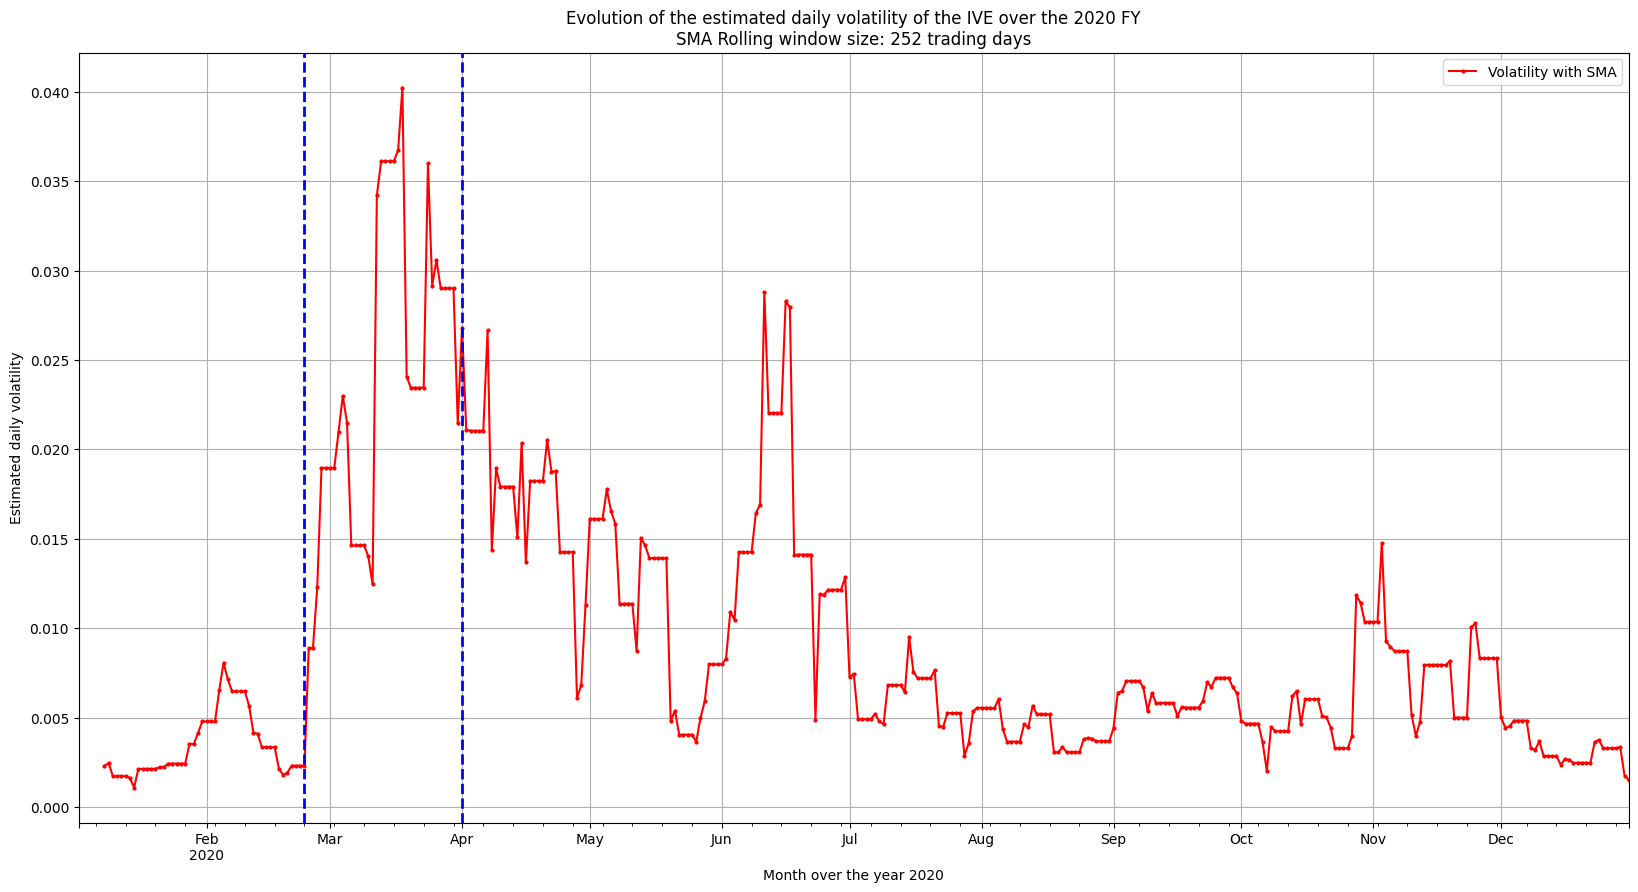

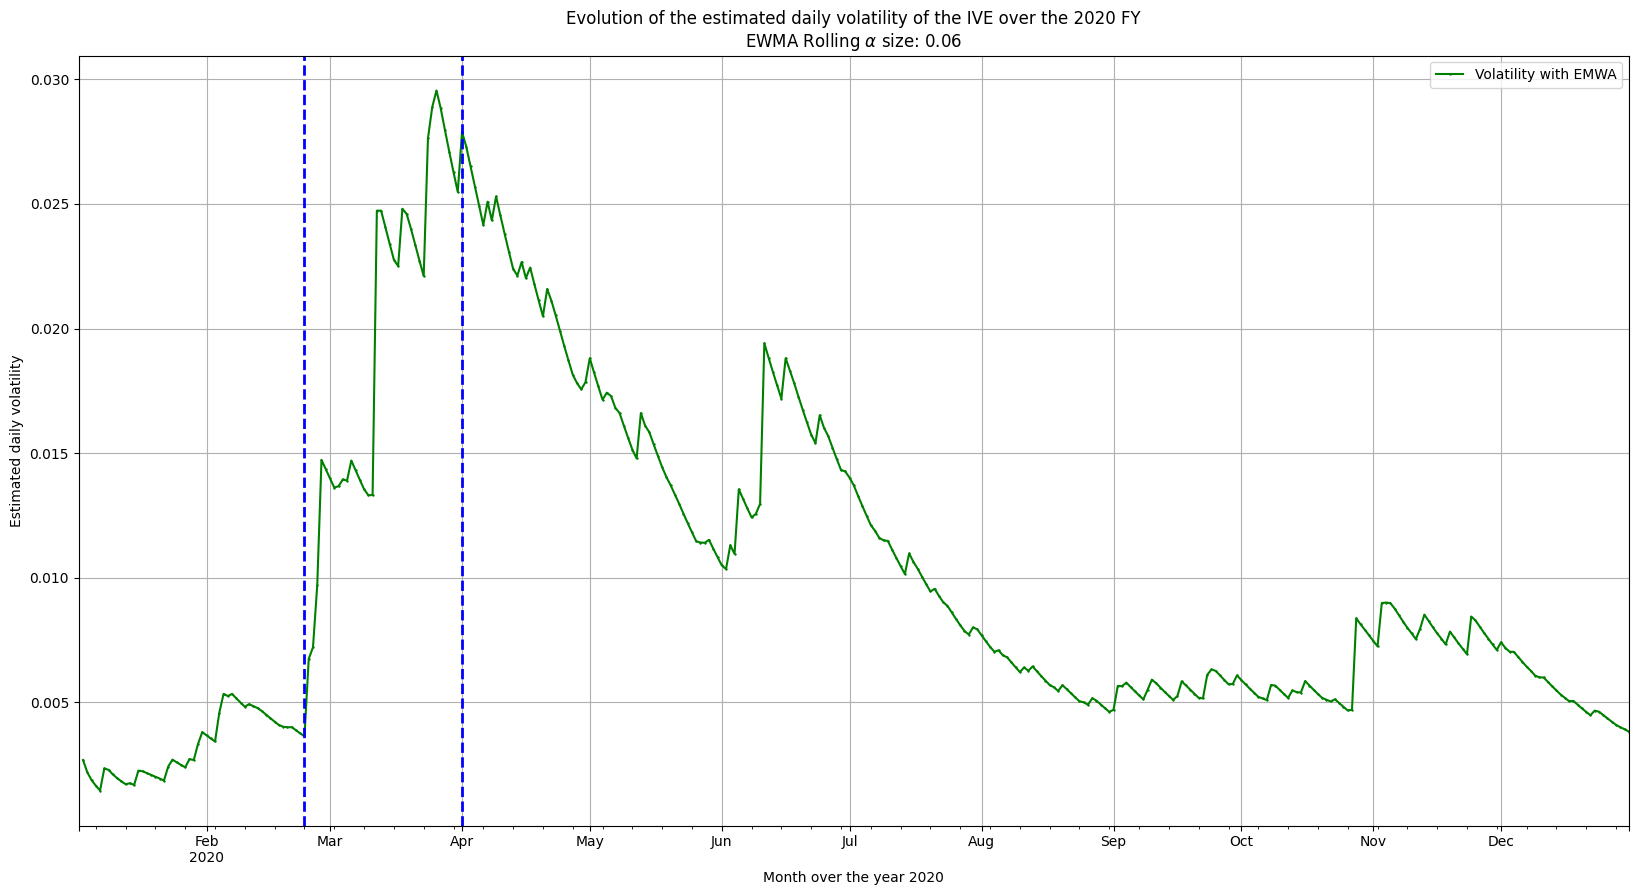

In [196]:
# Plotting the estimated daily volatility with SMA method
volatility["SMA"].columns = ["Volatility with SMA"]
volatility["EWMA"].columns = ["Volatility with EMWA"]
_ = volatility["SMA"].plot(color="red", figsize=(20, 10), marker='o', ms=2)
_ = plt.title("Evolution of the estimated daily volatility of the IVE over the 2020 FY\nSMA Rolling window size: 252 trading days")
_ = plt.xlabel("Month over the year 2020")
_ = plt.ylabel("Estimated daily volatility")
_ = plt.axvline(x = pd.to_datetime('2020-02-24'), color="blue", lw=2, linestyle="--")
_ = plt.axvline(x = pd.to_datetime('2020-04-01'), color="blue", lw=2, linestyle="--")
plt.grid()

# Plotting the estimated daily volatility with EWMA method
_ = volatility["EWMA"].plot(color="green", figsize=(20, 10), marker='+', ms=2)
_ = plt.title("Evolution of the estimated daily volatility of the IVE over the 2020 FY" + "\n" + r"EWMA Rolling $\alpha$ size: 0.06")
_ = plt.xlabel("Month over the year 2020")
_ = plt.ylabel("Estimated daily volatility")
_ = plt.axvline(x = pd.to_datetime('2020-02-24'), color="blue", lw=2, linestyle="--")
_ = plt.axvline(x = pd.to_datetime('2020-04-01'), color="blue", lw=2, linestyle="--")
plt.grid()

**Conclusion**: We have successfully computed and drawn the evolution of the estimated daily volatility. We can finally see high peaks related to the two Covid surges (March and November 2020).

---

**Lucas RODRIGUEZ** &bullet; 2022/2023